# Crime Rate Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

## Reading Whole Dataset & Preprocessing

In [2]:
crime_df_ = pd.read_csv('NYPD_Complaint_Data_Historic.csv')
for x in ['CMPLNT_FR_DT', 'BORO_NM']:
    crime_df_ = crime_df_[crime_df_[x].notna()]
    
crime_df_['Year'] = crime_df_['CMPLNT_FR_DT'].str.split('/').str[2].astype('int64')
crime_df_ = crime_df_[crime_df_['Year'] >= 2006]
crime_df_ = crime_df_[crime_df_['Year'] <= 2016]

crime_population_df = pd.read_csv('Total Population.csv')
crime_income_df = pd.read_csv('Median Incomes.csv')
crime_unemployment_df = pd.read_csv('Unemployment Rate.csv')
crime_enrollment_df = pd.read_csv('Enrollment.csv')


# Merging crime dataset to our dataset on date (YY-MM-DD)
crime_df_ = pd.merge(crime_df_, crime_population_df, on=['Year', 'BORO_NM'], how = 'left')
crime_df_ = pd.merge(crime_df_, crime_income_df, on=['Year', 'BORO_NM'], how = 'left')
crime_df_ = pd.merge(crime_df_, crime_unemployment_df, on=['Year', 'BORO_NM'], how = 'left')
crime_df_ = pd.merge(crime_df_, crime_enrollment_df, on=['Year', 'BORO_NM'], how = 'left')

crime_df_ = crime_df_.drop(
['SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'Latitude', 'Longitude', 'PATROL_BORO', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'CMPLNT_NUM', 'CMPLNT_TO_DT',
'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'PD_CD', 'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT',	'X_COORD_CD', 'Y_COORD_CD',
'TRANSIT_DISTRICT',	'Lat_Lon', 'STATION_NAME', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD',
'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'HOUSING_PSA']
, axis=1)
crime_df_ = crime_df_.reset_index(drop=True)

crime_df_ = crime_df_[crime_df_['BORO_NM']=='MANHATTAN']
crime_df_ = crime_df_.drop(['BORO_NM'], axis=1)
crime_df_ = crime_df_.reset_index(drop=True)
crime_df_

/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3098: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Year,Population,Median Incomes,Unemployment Rate,Enrollments
0,2006,1611581,76288,0.06751,165867
1,2006,1611581,76288,0.06751,165867
2,2014,1636268,82250,0.06600,154085
3,2013,1626159,79356,0.07493,155659
4,2011,1601948,75527,0.08969,157770
...,...,...,...,...,...
1328129,2010,1586698,75009,0.09173,158431
1328130,2015,1644518,81553,0.06100,175366
1328131,2010,1586698,75009,0.09173,158431
1328132,2016,1643734,82629,0.05500,177179


In [3]:
crime_df_prediction = crime_df_.copy()

In [4]:
def generateLineGraphYearly(df,columnName):
    crimeFreq = dict(Counter(df[columnName]))
    crimeFreqSorted = crimeFreq.items()

    crimeFreqSorted = dict(sorted(crimeFreqSorted))


    data = {'Year': list(crimeFreqSorted.keys()),
        'Crime_Frequency': list(crimeFreqSorted.values())}

    temp_df = pd.DataFrame(data,columns=['Year','Crime_Frequency'])

    plt.figure(figsize = (10, 5))
    plt.plot(temp_df['Year'], temp_df['Crime_Frequency'], color='red', marker='o')
    plt.title('Trends in Crime Frequency Yearly', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=90)
    plt.ylabel('Crime Frequency', fontsize=14)
    plt.grid(True)
    plt.show()

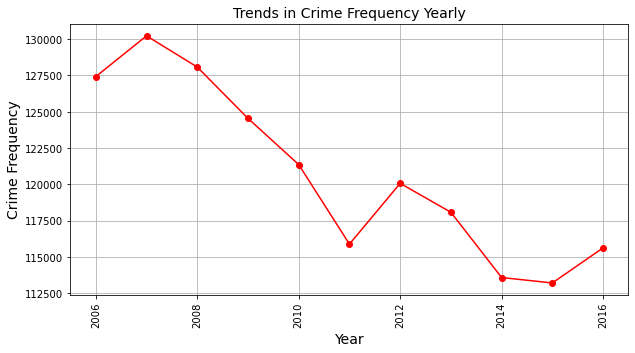

In [5]:
generateLineGraphYearly(crime_df_,'Year')

In [5]:
def splitTrainTest(df,column,value1,value2):
    # Choosing what to predict
    df = dict(Counter(df[column]))
    df = sorted(df.items(), key=lambda x: x[0]) #sorting in ascending by key
    df = dict((x, y) for x, y in df)

    df = pd.DataFrame(df.items(), columns=[column,'Crimes'])
    print(df)
    
    train = df[df[column] <= value1].to_numpy()
    test = df[df[column] >= value2].to_numpy()

    return train,test

In [6]:
def plotDatasetSplit(train_df, test_df, label):
    column_size = train_df.shape[1]

    train_x = train_df[:,column_size-2]
    train_y = train_df[:,column_size-1]
    test_x = test_df[:,column_size-2]
    test_y = test_df[:,column_size-1]

    plt.plot(train_x, train_y, color = "black")
    plt.plot(test_x, test_y, color = "red")
    plt.ylabel('Crime Frequency')
    plt.xlabel(label)
    plt.title("Train/Test split for Crime Data by "+label)
    plt.show()
    
    train_x = train_x.reshape(-1, 1)
    train_y = train_y.reshape(-1, 1)
    test_x = test_x.reshape(-1, 1)
    test_y = test_y.reshape(-1, 1)

    return train_x,train_y,test_x,test_y

In [8]:
crime_df_prediction

,Year,Population,Median Incomes,Unemployment Rate,Enrollments
0,2006,1611581,76288,0.06751,165867
1,2006,1611581,76288,0.06751,165867
2,2014,1636268,82250,0.06600,154085
3,2013,1626159,79356,0.07493,155659
4,2011,1601948,75527,0.08969,157770
...,...,...,...,...,...
1328129,2010,1586698,75009,0.09173,158431
1328130,2015,1644518,81553,0.06100,175366
1328131,2010,1586698,75009,0.09173,158431
1328132,2016,1643734,82629,0.05500,177179


    Year  Crimes
0   2006  127424
1   2007  130229
2   2008  128080
3   2009  124548
4   2010  121364
5   2011  115889
6   2012  120076
7   2013  118083
8   2014  113590
9   2015  113218
10  2016  115633


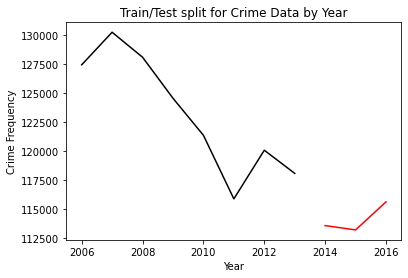

In [7]:
train_year, test_year = splitTrainTest(crime_df_prediction,'Year',2013,2014)
train_x_year, train_y_year, test_x_year, test_y_year = plotDatasetSplit(train_year, test_year, 'Year')

In [8]:
def splitTestSet(test_x_set, test_y_set, num1, num2):
    return test_x_set[num1:num2], test_y_set[num1:num2]

In [9]:
test_x_year_2014, test_y_year_2014 = splitTestSet(test_x_year, test_y_year, 0, 1)
test_x_year_2015, test_y_year_2015 = splitTestSet(test_x_year, test_y_year, 1, 2)
test_x_year_2016, test_y_year_2016 = splitTestSet(test_x_year, test_y_year, 2, 3)

## Building Models that Predict Future Crime Rate & Outputting Errors

### No Additional Data

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Linear Regression

In [11]:
def linearRegression(train_x, train_y, test_x, test_y):
    """ Building Linear Regression  """

    regressor = LinearRegression()
    regressor.fit(train_x, train_y) # Training model
    y_pred_regressor = regressor.predict(test_x) # Predicting future data


    # Evaluating Model using 4 different errors :- MAE,MAPE,MSE,RMSE
    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_regressor))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_regressor))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_regressor))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_regressor)))

In [14]:
linearRegression(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014)
linearRegression(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015)
linearRegression(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016)


Mean Absolute Error: 1269.357142857276
Mean Absolute % Error: 1.1174902217248666
Mean Squared Error: 1611267.5561227868
Root Mean Squared Error: 1269.357142857276

Mean Absolute Error: 214.7023809524253
Mean Absolute % Error: 0.18963626009329373
Mean Squared Error: 46097.11238664036
Root Mean Squared Error: 214.7023809524253

Mean Absolute Error: 4485.761904761661
Mean Absolute % Error: 3.8793094573016877
Mean Squared Error: 20122059.866210964
Root Mean Squared Error: 4485.761904761661


#### Decision Tree Regressor

In [12]:
def decisionTreeRegressor(train_x, train_y, test_x, test_y):
    """ Building Decision Tree Regressor """
    dtr = DecisionTreeRegressor(random_state=0)
    dtr.fit(train_x, train_y) # Training model
    y_pred_dtr = dtr.predict(test_x) # Predicting future data

    # Evaluating Model using 4 different errors :- MAE,MAPE,MSE,RMSE
    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_dtr))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_dtr))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_dtr))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_dtr)))

In [16]:
decisionTreeRegressor(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014)
decisionTreeRegressor(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015)
decisionTreeRegressor(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [13]:
def randomForestRegressor(train_x, train_y, test_x, test_y):
    """ Building a Random Forest Regressor """

    rfr = RandomForestRegressor(random_state=0, n_estimators=150)
    rfr.fit(train_x, train_y) # Training model
    y_pred_rfr = rfr.predict(test_x) # Predicting future data

    # Evaluating Model using 4 different errors :- MAE,MAPE,MSE,RMSE
    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_rfr))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_rfr))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_rfr))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_rfr)))

In [16]:
randomForestRegressor(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014)
randomForestRegressor(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015)
randomForestRegressor(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016)

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_85414/3192713231.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(train_x, train_y) # Training model
/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_85414/3192713231.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(train_x, train_y) # Training model



Mean Absolute Error: 4870.139999999999
Mean Absolute % Error: 4.28747248877542
Mean Squared Error: 23718263.619599994
Root Mean Squared Error: 4870.139999999999

Mean Absolute Error: 5242.139999999999
Mean Absolute % Error: 4.630129484710912
Mean Squared Error: 27480031.779599994
Root Mean Squared Error: 5242.139999999999

Mean Absolute Error: 2827.1399999999994
Mean Absolute % Error: 2.4449248916831694
Mean Squared Error: 7992720.579599997
Root Mean Squared Error: 2827.1399999999994


/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_85414/3192713231.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(train_x, train_y) # Training model


#### Gradient Boosting Regressor

In [17]:
def gradientBoostingRegressor(train_x, train_y, test_x, test_y):
    gbr = GradientBoostingRegressor(random_state=0)
    gbr.fit(train_x, train_y)

    y_pred_gbr = gbr.predict(test_x)

    # Evaluating Model using 4 different errors :- MAE,MAPE,MSE,RMSE
    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_gbr))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_gbr))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_gbr))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_gbr)))

In [18]:
gradientBoostingRegressor(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014)
gradientBoostingRegressor(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015)
gradientBoostingRegressor(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016)


Mean Absolute Error: 4493.268465493558
Mean Absolute % Error: 3.955690171224191
Mean Squared Error: 20189461.502998836
Root Mean Squared Error: 4493.268465493558

Mean Absolute Error: 4865.268465493558
Mean Absolute % Error: 4.297257031120103
Mean Squared Error: 23670837.241326045
Root Mean Squared Error: 4865.268465493558

Mean Absolute Error: 2450.2684654935583
Mean Absolute % Error: 2.119004493088961
Mean Squared Error: 6003815.552992157
Root Mean Squared Error: 2450.2684654935583


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


#### Multi Layer Perceptron Regressor

In [14]:
def mlp_regressor(train_x, train_y, test_x, test_y, hidden_layer, activation):
    mlp_regress = MLPRegressor(random_state=1, activation=activation, hidden_layer_sizes=hidden_layer, max_iter=20000).fit(train_x, train_y)

    y_pred_mlp = mlp_regress.predict(test_x)

    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_mlp))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_mlp))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_mlp))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_mlp)))

In [158]:
mlp_regressor(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014, (100,), 'relu')
mlp_regressor(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015, (100,), 'relu')
mlp_regressor(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016, (100,), 'relu')

/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Mean Absolute Error: 4543.569140841049
Mean Absolute % Error: 3.9999728328559288
Mean Squared Error: 20644020.537603073
Root Mean Squared Error: 4543.569140841049


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Mean Absolute Error: 4974.19774882152
Mean Absolute % Error: 4.393469014486671
Mean Squared Error: 24742643.244381074
Root Mean Squared Error: 4974.19774882152


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Mean Absolute Error: 2617.82635680199
Mean Absolute % Error: 2.263909400259433
Mean Squared Error: 6853014.834367181
Root Mean Squared Error: 2617.82635680199


#### SGD Regressor

In [15]:
def sgd_regressor(train_x, train_y, test_x, test_y):
    sgd_regress = make_pipeline(StandardScaler(), SGDRegressor(max_iter=20000, tol=1e-3)).fit(train_x, train_y)
    y_pred_sgd = sgd_regress.predict(test_x)

    print('\nMean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred_sgd))
    print('Mean Absolute % Error:', mean_absolute_percentage_error(test_y, y_pred_sgd))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred_sgd))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_sgd)))

In [94]:
sgd_regressor(train_x_year, train_y_year, test_x_year_2014, test_y_year_2014)
sgd_regressor(train_x_year, train_y_year, test_x_year_2015, test_y_year_2015)
sgd_regressor(train_x_year, train_y_year, test_x_year_2016, test_y_year_2016)


Mean Absolute Error: 3849.325565453997
Mean Absolute % Error: 3.3887891235619305
Mean Squared Error: 14817307.308857735
Root Mean Squared Error: 3849.325565453997

Mean Absolute Error: 3655.0096341666795
Mean Absolute % Error: 3.228293764389655
Mean Squared Error: 13359095.425851244
Root Mean Squared Error: 3655.0096341666795

Mean Absolute Error: 674.2385497524665
Mean Absolute % Error: 0.5830848890476477
Mean Squared Error: 454597.62197230925
Root Mean Squared Error: 674.2385497524665


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergenc

### Population Data

In [16]:
# Merging Total Crime with Additional Data

df_crime_per_year = dict(Counter(crime_df_prediction['Year']))
df_crime_per_year = sorted(df_crime_per_year.items(), key=lambda x: x[0]) #sorting in ascending by key
df_crime_per_year = dict((x, y) for x, y in df_crime_per_year)
df_crime_per_year = pd.DataFrame(df_crime_per_year.items(), columns=['Year','Crimes'])

crime_df_prediction = pd.merge(df_crime_per_year, crime_df_prediction, on=['Year'], how = 'inner')

crime_df_prediction = crime_df_prediction[['Year', 'Median Incomes', 'Population', 'Enrollments', 'Unemployment Rate', 'Crimes']]

In [19]:
crime_df_prediction_population = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Crimes'].max()

crime_df_prediction_population

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_62387/2986953312.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_population = crime_df_prediction.groupby(['Year'],as_index=False)['Median Incomes', 'Population', 'Unemployment Rate', 'Crimes'].max()


,Year,Median Incomes,Population,Unemployment Rate,Crimes
0,2006,76288,1611581,0.06751,127424
1,2007,79375,1620867,0.06791,130229
2,2008,82153,1634795,0.06664,128080
3,2009,82068,1629054,0.09691,124548
4,2010,75009,1586698,0.09173,121364
5,2011,75527,1601948,0.08969,115889
6,2012,74853,1619090,0.08816,120076
7,2013,79356,1626159,0.07493,118083
8,2014,82250,1636268,0.06600,113590
9,2015,81553,1644518,0.06100,113218


In [161]:
#Splitting the dataset

train_year_population = crime_df_prediction_population[crime_df_prediction_population['Year'] <= 2013].to_numpy()
test_year_population = crime_df_prediction_population[crime_df_prediction_population['Year'] >= 2014].to_numpy()

column_size = train_year_population.shape[1]

train_x_year_population = train_year_population[:,[0,1]]
train_y_year_population = train_year_population[:,column_size-1]
test_x_year_population = test_year_population[:,[0,1]]
test_y_year_population = test_year_population[:,column_size-1]

In [162]:
test_x_year_population_2014, test_y_year_population_2014 = splitTestSet(test_x_year_population, test_y_year_population, 0, 1)
test_x_year_population_2015, test_y_year_population_2015 = splitTestSet(test_x_year_population, test_y_year_population, 1, 2)
test_x_year_population_2016, test_y_year_population_2016 = splitTestSet(test_x_year_population, test_y_year_population, 2, 3)

#### Multiple Linear Regression

In [163]:
linearRegression(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014)
linearRegression(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015)
linearRegression(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016)


Mean Absolute Error: 4365.10473543033
Mean Absolute % Error: 3.8428600540807554
Mean Squared Error: 19054139.351276293
Root Mean Squared Error: 4365.10473543033

Mean Absolute Error: 3468.673384293914
Mean Absolute % Error: 3.063711940057159
Mean Squared Error: 12031695.046908993
Root Mean Squared Error: 3468.673384293914

Mean Absolute Error: 5757.309341805056
Mean Absolute % Error: 4.978950076366656
Mean Squared Error: 33146610.857235763
Root Mean Squared Error: 5757.309341805056


#### Decision Tree Regressor

In [164]:
decisionTreeRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014)
decisionTreeRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015)
decisionTreeRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [165]:
randomForestRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014)
randomForestRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015)
randomForestRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016)


Mean Absolute Error: 4936.706666666665
Mean Absolute % Error: 4.346075065293305
Mean Squared Error: 24371072.712711096
Root Mean Squared Error: 4936.706666666665

Mean Absolute Error: 5308.706666666665
Mean Absolute % Error: 4.688924611516424
Mean Squared Error: 28182366.472711094
Root Mean Squared Error: 5308.706666666665

Mean Absolute Error: 2893.706666666665
Mean Absolute % Error: 2.5024920798272685
Mean Squared Error: 8373538.272711102
Root Mean Squared Error: 2893.706666666665


#### Gradient Boosting Regressor

In [103]:
gradientBoostingRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014)
gradientBoostingRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015)
gradientBoostingRegressor(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016)


Mean Absolute Error: 4493.020452277153
Mean Absolute % Error: 3.955471830510743
Mean Squared Error: 20187232.78458079
Root Mean Squared Error: 4493.020452277153

Mean Absolute Error: 4865.020452277153
Mean Absolute % Error: 4.297037973005311
Mean Squared Error: 23668424.001074992
Root Mean Squared Error: 4865.020452277153

Mean Absolute Error: 2450.020452277153
Mean Absolute % Error: 2.11879001001198
Mean Squared Error: 6002600.216576344
Root Mean Squared Error: 2450.020452277153


#### Multi Layer Perceptron Regressor

In [104]:
mlp_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014, (100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015, (100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016, (100,100,100,100,100,100,100), 'relu')


Mean Absolute Error: 10831.510238939605
Mean Absolute % Error: 9.535619543040413
Mean Squared Error: 117321614.05625351
Root Mean Squared Error: 10831.510238939605

Mean Absolute Error: 11830.886297282312
Mean Absolute % Error: 10.449651378122129
Mean Squared Error: 139969870.57922238
Root Mean Squared Error: 11830.886297282312

Mean Absolute Error: 9356.260701806474
Mean Absolute % Error: 8.091341314163323
Mean Squared Error: 87539614.32016817
Root Mean Squared Error: 9356.260701806474


#### SGD Regressor

In [105]:
sgd_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2014, test_y_year_population_2014)
sgd_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2015, test_y_year_population_2015)
sgd_regressor(train_x_year_population, train_y_year_population, test_x_year_population_2016, test_y_year_population_2016)


Mean Absolute Error: 3602.531223640035
Mean Absolute % Error: 3.1715214575579145
Mean Squared Error: 12978231.217301369
Root Mean Squared Error: 3602.531223640035

Mean Absolute Error: 3182.173246673119
Mean Absolute % Error: 2.8106601836043024
Mean Squared Error: 10126226.57184214
Root Mean Squared Error: 3182.173246673119

Mean Absolute Error: 489.4295916051051
Mean Absolute % Error: 0.4232611725070742
Mean Squared Error: 239541.32513873995
Root Mean Squared Error: 489.4295916051051


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Median Incomes Data

In [11]:
# Merging Total Crime with Additional Data

df_crime_per_year = dict(Counter(crime_df_prediction['Year']))
df_crime_per_year = sorted(df_crime_per_year.items(), key=lambda x: x[0]) #sorting in ascending by key
df_crime_per_year = dict((x, y) for x, y in df_crime_per_year)
df_crime_per_year = pd.DataFrame(df_crime_per_year.items(), columns=['Year','Crimes'])

crime_df_prediction = pd.merge(df_crime_per_year, crime_df_prediction, on=['Year'], how = 'inner')

crime_df_prediction = crime_df_prediction[['Year', 'Median Incomes', 'Population', 'Enrollments', 'Unemployment Rate', 'Crimes']]

crime_df_prediction_median = crime_df_prediction.groupby(['Year'],as_index=False)['Median Incomes', 'Crimes'].max()

#Splitting the dataset

train_year_median = crime_df_prediction_median[crime_df_prediction_median['Year'] <= 2013].to_numpy()
test_year_median = crime_df_prediction_median[crime_df_prediction_median['Year'] >= 2014].to_numpy()

column_size = train_year_median.shape[1]

train_x_year_median = train_year_median[:,[0,1]]
train_y_year_median = train_year_median[:,column_size-1]
test_x_year_median = test_year_median[:,[0,1]]
test_y_year_median = test_year_median[:,column_size-1]

test_x_year_median_2014, test_y_year_median_2014 = splitTestSet(test_x_year_median, test_y_year_median, 0, 1)
test_x_year_median_2015, test_y_year_median_2015 = splitTestSet(test_x_year_median, test_y_year_median, 1, 2)
test_x_year_median_2016, test_y_year_median_2016 = splitTestSet(test_x_year_median, test_y_year_median, 2, 3)

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_88449/3779647646.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_median = crime_df_prediction.groupby(['Year'],as_index=False)['Median Incomes', 'Crimes'].max()


#### Multiple Linear Regression

In [14]:
linearRegression(train_x_year_median, train_y_year_median, test_x_year_median_2014, test_y_year_median_2014)
linearRegression(train_x_year_median, train_y_year_median, test_x_year_median_2015, test_y_year_median_2015)
linearRegression(train_x_year_median, train_y_year_median, test_x_year_median_2016, test_y_year_median_2016)


Mean Absolute Error: 3068.1573130913894
Mean Absolute % Error: 2.7010804763547758
Mean Squared Error: 9413589.297876174
Root Mean Squared Error: 3068.1573130913894

Mean Absolute Error: 3382.6042524168734
Mean Absolute % Error: 2.9876912261450244
Mean Squared Error: 11442011.528468715
Root Mean Squared Error: 3382.6042524168734

Mean Absolute Error: 444.2254569209181
Mean Absolute % Error: 0.3841684094686794
Mean Squared Error: 197336.25657659845
Root Mean Squared Error: 444.2254569209181


#### Random Forest Regressor

In [ ]:
randomForestRegressor(train_x_year_median, train_y_year_median, test_x_year_median_2014, test_y_year_median_2014)
randomForestRegressor(train_x_year_median, train_y_year_median, test_x_year_median_2015, test_y_year_median_2015)
randomForestRegressor(train_x_year_median, train_y_year_median, test_x_year_median_2016, test_y_year_median_2016)


Mean Absolute Error: 6742.639999999999
Mean Absolute % Error: 5.935945065586759
Mean Squared Error: 45463194.169599995
Root Mean Squared Error: 6742.639999999999

Mean Absolute Error: 7067.546666666662
Mean Absolute % Error: 6.242423171816021
Mean Squared Error: 49950215.88551104
Root Mean Squared Error: 7067.546666666662

Mean Absolute Error: 4699.639999999999
Mean Absolute % Error: 4.064272309807753
Mean Squared Error: 22086616.129599996
Root Mean Squared Error: 4699.639999999999


#### MLP Regressor

In [ ]:
mlp_regressor(train_x_year_median, train_y_year_median, test_x_year_median_2014, test_y_year_median_2014, (100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_median, train_y_year_median, test_x_year_median_2015, test_y_year_median_2015, (100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_median, train_y_year_median, test_x_year_median_2016, test_y_year_median_2016, (100,100,100,100,100), 'relu')


Mean Absolute Error: 11456.927811615504
Mean Absolute % Error: 10.086211648574261
Mean Squared Error: 131261194.88056882
Root Mean Squared Error: 11456.927811615504

Mean Absolute Error: 10768.778345071973
Mean Absolute % Error: 9.511542639043236
Mean Squared Error: 115966587.04529105
Root Mean Squared Error: 10768.778345071973

Mean Absolute Error: 9990.325174075231
Mean Absolute % Error: 8.639683458939256
Mean Squared Error: 99806597.0837613
Root Mean Squared Error: 9990.325174075231


### Population + Median Incomes Data

In [106]:
crime_df_prediction_population_income = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Median Incomes','Crimes'].max()

crime_df_prediction_population_income

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_58110/3658104071.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_population_income = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Median Incomes','Crimes'].max()


,Year,Population,Median Incomes,Crimes
0,2010,1586698,75009,121364
1,2011,1601948,75527,115889
2,2012,1619090,74853,120076
3,2013,1626159,79356,118083
4,2014,1636268,82250,113590
5,2015,1644518,81553,113218
6,2016,1643734,82629,115633


In [107]:
#Splitting the dataset

train_year_population_income = crime_df_prediction_population_income[crime_df_prediction_population_income['Year'] <= 2013].to_numpy()
test_year_population_income = crime_df_prediction_population_income[crime_df_prediction_population_income['Year'] >= 2014].to_numpy()

column_size = train_year_population_income.shape[1]

train_x_year_population_income = train_year_population_income[:,[0,1,2]]
train_y_year_population_income = train_year_population_income[:,column_size-1]
test_x_year_population_income = test_year_population_income[:,[0,1,2]]
test_y_year_population_income = test_year_population_income[:,column_size-1]

In [108]:
test_x_year_population_income_2014, test_y_year_population_income_2014 = splitTestSet(test_x_year_population_income, test_y_year_population_income, 0, 1)
test_x_year_population_income_2015, test_y_year_population_income_2015 = splitTestSet(test_x_year_population_income, test_y_year_population_income, 1, 2)
test_x_year_population_income_2016, test_y_year_population_income_2016 = splitTestSet(test_x_year_population_income, test_y_year_population_income, 2, 3)

##### Multiple Linear Regression

In [109]:
linearRegression(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014)
linearRegression(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015)
linearRegression(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016)


Mean Absolute Error: 6168.919365644455
Mean Absolute % Error: 5.430864834619645
Mean Squared Error: 38055566.13982318
Root Mean Squared Error: 6168.919365644455

Mean Absolute Error: 183070.93022835255
Mean Absolute % Error: 161.69772494510815
Mean Squared Error: 33514965494.674328
Root Mean Squared Error: 183070.93022835255

Mean Absolute Error: 462742.8675124645
Mean Absolute % Error: 400.1823592853809
Mean Squared Error: 214130961433.6583
Root Mean Squared Error: 462742.8675124645


##### Decision Tree Regressor

In [110]:
decisionTreeRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014)
decisionTreeRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015)
decisionTreeRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [111]:
randomForestRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014)
randomForestRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015)
randomForestRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016)


Mean Absolute Error: 4144.393333333326
Mean Absolute % Error: 3.6485547436687438
Mean Squared Error: 17175996.10137772
Root Mean Squared Error: 4144.393333333326

Mean Absolute Error: 4516.393333333326
Mean Absolute % Error: 3.9891124497282466
Mean Squared Error: 20397808.74137771
Root Mean Squared Error: 4516.393333333326

Mean Absolute Error: 2101.393333333326
Mean Absolute % Error: 1.8172955240574284
Mean Squared Error: 4415853.941377748
Root Mean Squared Error: 2101.393333333326


#### Gradient Boosting Regressor

In [112]:
gradientBoostingRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014)
gradientBoostingRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015)
gradientBoostingRegressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016)


Mean Absolute Error: 4493.020452277153
Mean Absolute % Error: 3.955471830510743
Mean Squared Error: 20187232.78458079
Root Mean Squared Error: 4493.020452277153

Mean Absolute Error: 4865.020452277153
Mean Absolute % Error: 4.297037973005311
Mean Squared Error: 23668424.001074992
Root Mean Squared Error: 4865.020452277153

Mean Absolute Error: 2450.020452277153
Mean Absolute % Error: 2.11879001001198
Mean Squared Error: 6002600.216576344
Root Mean Squared Error: 2450.020452277153


#### Multi Layer Perceptron Regressor

In [113]:
mlp_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014, (100,100,100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015, (100,100,100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016, (100,100,100,100,100,100,100,100,100), 'relu')


Mean Absolute Error: 1846.86137040623
Mean Absolute % Error: 1.6259013737179595
Mean Squared Error: 3410896.921498778
Root Mean Squared Error: 1846.86137040623

Mean Absolute Error: 2771.0666868881526
Mean Absolute % Error: 2.4475495830063707
Mean Squared Error: 7678810.5831812825
Root Mean Squared Error: 2771.0666868881526

Mean Absolute Error: 330.9248249504162
Mean Absolute % Error: 0.286185453071715
Mean Squared Error: 109511.23976846362
Root Mean Squared Error: 330.9248249504162


#### SGD Regressor

In [114]:
sgd_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2014, test_y_year_population_income_2014)
sgd_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2015, test_y_year_population_income_2015)
sgd_regressor(train_x_year_population_income, train_y_year_population_income, test_x_year_population_income_2016, test_y_year_population_income_2016)


Mean Absolute Error: 3082.3748120819364
Mean Absolute % Error: 2.713596982200842
Mean Squared Error: 9501034.482157152
Root Mean Squared Error: 3082.3748120819364

Mean Absolute Error: 3631.794048430733
Mean Absolute % Error: 3.207788556970387
Mean Squared Error: 13189928.010216892
Root Mean Squared Error: 3631.794048430733

Mean Absolute Error: 1088.0311779736949
Mean Absolute % Error: 0.9409348351886528
Mean Squared Error: 1183811.844242826
Root Mean Squared Error: 1088.0311779736949


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Population + Median Income + Unemployment Rate

In [115]:
crime_df_prediction_population_income_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Median Incomes', 'Unemployment Rate','Crimes'].max()

crime_df_prediction_population_income_unemployment

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_58110/3192376069.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_population_income_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Median Incomes', 'Unemployment Rate','Crimes'].max()


,Year,Population,Median Incomes,Unemployment Rate,Crimes
0,2010,1586698,75009,0.09173,121364
1,2011,1601948,75527,0.08969,115889
2,2012,1619090,74853,0.08816,120076
3,2013,1626159,79356,0.07493,118083
4,2014,1636268,82250,0.06600,113590
5,2015,1644518,81553,0.06100,113218
6,2016,1643734,82629,0.05500,115633


In [116]:
#Splitting the dataset

train_year_population_income_unemployment = crime_df_prediction_population_income_unemployment[crime_df_prediction_population_income_unemployment['Year'] <= 2013].to_numpy()
test_year_population_income_unemployment = crime_df_prediction_population_income_unemployment[crime_df_prediction_population_income_unemployment['Year'] >= 2014].to_numpy()

column_size = train_year_population_income_unemployment.shape[1]

train_x_year_population_income_unemployment = train_year_population_income_unemployment[:,[0,1,2,3]]
train_y_year_population_income_unemployment = train_year_population_income_unemployment[:,column_size-1]
test_x_year_population_income_unemployment = test_year_population_income_unemployment[:,[0,1,2,3]]
test_y_year_population_income_unemployment = test_year_population_income_unemployment[:,column_size-1]

In [117]:
test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014 = splitTestSet(test_x_year_population_income_unemployment, test_y_year_population_income_unemployment, 0, 1)
test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015 = splitTestSet(test_x_year_population_income_unemployment, test_y_year_population_income_unemployment, 1, 2)
test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016 = splitTestSet(test_x_year_population_income_unemployment, test_y_year_population_income_unemployment, 2, 3)

#### Multiple Linear Regression

In [118]:
linearRegression(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014)
linearRegression(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015)
linearRegression(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016)


Mean Absolute Error: 6139.918611168861
Mean Absolute % Error: 5.40533375400023
Mean Squared Error: 37698600.55177776
Root Mean Squared Error: 6139.918611168861

Mean Absolute Error: 181957.2614070177
Mean Absolute % Error: 160.71407497660948
Mean Squared Error: 33108444978.741776
Root Mean Squared Error: 181957.2614070177

Mean Absolute Error: 459732.7607014179
Mean Absolute % Error: 397.5792037752354
Mean Squared Error: 211354211262.1472
Root Mean Squared Error: 459732.7607014179


#### Decision Tree Regressor

In [119]:
decisionTreeRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014)
decisionTreeRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015)
decisionTreeRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [120]:
randomForestRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014)
randomForestRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015)
randomForestRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016)


Mean Absolute Error: 4245.306666666671
Mean Absolute % Error: 3.7373947237139458
Mean Squared Error: 18022628.694044482
Root Mean Squared Error: 4245.306666666671

Mean Absolute Error: 4617.306666666671
Mean Absolute % Error: 4.0782443309956635
Mean Squared Error: 21319520.854044482
Root Mean Squared Error: 4617.306666666671

Mean Absolute Error: 2202.306666666671
Mean Absolute % Error: 1.9045658822885083
Mean Squared Error: 4850154.654044463
Root Mean Squared Error: 2202.306666666671


#### Gradient Boosting Regressor

In [121]:
gradientBoostingRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014)
gradientBoostingRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015)
gradientBoostingRegressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016)


Mean Absolute Error: 4493.020452277153
Mean Absolute % Error: 3.955471830510743
Mean Squared Error: 20187232.78458079
Root Mean Squared Error: 4493.020452277153

Mean Absolute Error: 4865.020452277153
Mean Absolute % Error: 4.297037973005311
Mean Squared Error: 23668424.001074992
Root Mean Squared Error: 4865.020452277153

Mean Absolute Error: 2450.020452277153
Mean Absolute % Error: 2.11879001001198
Mean Squared Error: 6002600.216576344
Root Mean Squared Error: 2450.020452277153


#### Multi Layer Perceptron Regressor

In [122]:
mlp_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014, (100,100,100,100,100,100,100,100), 'identity')
mlp_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015, (100,100,100,100,100,100,100,100), 'identity')
mlp_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016, (100,100,100,100,100,100,100,100), 'identity')


Mean Absolute Error: 241.59402640996268
Mean Absolute % Error: 0.21268952056515775
Mean Squared Error: 58367.673596977744
Root Mean Squared Error: 241.59402640996268

Mean Absolute Error: 743.0281274403533
Mean Absolute % Error: 0.6562809159677377
Mean Squared Error: 552090.7981675179
Root Mean Squared Error: 743.0281274403533

Mean Absolute Error: 1767.6648810192855
Mean Absolute % Error: 1.5286854799402294
Mean Squared Error: 3124639.1315889247
Root Mean Squared Error: 1767.6648810192855


#### SGD Regressor

In [123]:
sgd_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2014, test_y_year_population_income_unemployment_2014)
sgd_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2015, test_y_year_population_income_unemployment_2015)
sgd_regressor(train_x_year_population_income_unemployment, train_y_year_population_income_unemployment, test_x_year_population_income_unemployment_2016, test_y_year_population_income_unemployment_2016)


Mean Absolute Error: 3036.8456847633643
Mean Absolute % Error: 2.6735149967104186
Mean Squared Error: 9222431.713065866
Root Mean Squared Error: 3036.8456847633643

Mean Absolute Error: 7526.855663619121
Mean Absolute % Error: 6.64810866083054
Mean Squared Error: 56653556.18095523
Root Mean Squared Error: 7526.855663619121

Mean Absolute Error: 6475.651498360297
Mean Absolute % Error: 5.600175986405522
Mean Squared Error: 41934062.328215964
Root Mean Squared Error: 6475.651498360297


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Unemployment Data

In [124]:
crime_df_prediction_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Unemployment Rate','Crimes'].max()

crime_df_prediction_unemployment

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_58110/667781964.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Unemployment Rate','Crimes'].max()


,Year,Unemployment Rate,Crimes
0,2010,0.09173,121364
1,2011,0.08969,115889
2,2012,0.08816,120076
3,2013,0.07493,118083
4,2014,0.06600,113590
5,2015,0.06100,113218
6,2016,0.05500,115633


In [125]:
#Splitting the dataset

train_year_unemployment = crime_df_prediction_unemployment[crime_df_prediction_unemployment['Year'] <= 2013].to_numpy()
test_year_unemployment = crime_df_prediction_unemployment[crime_df_prediction_unemployment['Year'] >= 2014].to_numpy()

column_size = train_year_unemployment.shape[1]

train_x_year_unemployment = train_year_unemployment[:,[0,1]]
train_y_year_unemployment = train_year_unemployment[:,column_size-1]
test_x_year_unemployment = test_year_unemployment[:,[0,1]]
test_y_year_unemployment = test_year_unemployment[:,column_size-1]

In [126]:
test_x_year_unemployment_2014, test_y_year_unemployment_2014 = splitTestSet(test_x_year_unemployment, test_y_year_unemployment, 0, 1)
test_x_year_unemployment_2015, test_y_year_unemployment_2015 = splitTestSet(test_x_year_unemployment, test_y_year_unemployment, 1, 2)
test_x_year_unemployment_2016, test_y_year_unemployment_2016 = splitTestSet(test_x_year_unemployment, test_y_year_unemployment, 2, 3)

#### Multiple Linear Regression

In [127]:
linearRegression(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014)
linearRegression(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015)
linearRegression(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016)


Mean Absolute Error: 3861.785267283907
Mean Absolute % Error: 3.3997581365295426
Mean Squared Error: 14913385.450611038
Root Mean Squared Error: 3861.785267283907

Mean Absolute Error: 3667.839912968222
Mean Absolute % Error: 3.239626130975836
Mean Squared Error: 13453049.627162734
Root Mean Squared Error: 3667.839912968222

Mean Absolute Error: 688.6839592519682
Mean Absolute % Error: 0.5955773518389803
Mean Squared Error: 474285.5957309666
Root Mean Squared Error: 688.6839592519682


#### Decision Tree Regressor

In [128]:
decisionTreeRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014)
decisionTreeRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015)
decisionTreeRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [129]:
randomForestRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014)
randomForestRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015)
randomForestRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016)


Mean Absolute Error: 4805.726666666669
Mean Absolute % Error: 4.230765619039237
Mean Squared Error: 23095008.794711135
Root Mean Squared Error: 4805.726666666669

Mean Absolute Error: 5177.726666666669
Mean Absolute % Error: 4.573236293404467
Mean Squared Error: 26808853.434711136
Root Mean Squared Error: 5177.726666666669

Mean Absolute Error: 2762.726666666669
Mean Absolute % Error: 2.389219917036373
Mean Squared Error: 7632658.634711125
Root Mean Squared Error: 2762.726666666669


#### Gradient Boosting Regressor

In [130]:
gradientBoostingRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014)
gradientBoostingRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015)
gradientBoostingRegressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016)


Mean Absolute Error: 4493.020452277153
Mean Absolute % Error: 3.955471830510743
Mean Squared Error: 20187232.78458079
Root Mean Squared Error: 4493.020452277153

Mean Absolute Error: 4865.020452277153
Mean Absolute % Error: 4.297037973005311
Mean Squared Error: 23668424.001074992
Root Mean Squared Error: 4865.020452277153

Mean Absolute Error: 2450.020452277153
Mean Absolute % Error: 2.11879001001198
Mean Squared Error: 6002600.216576344
Root Mean Squared Error: 2450.020452277153


#### Multiple Layer Perceptron

In [131]:
mlp_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014, (100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015, (100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016, (100,100,100,100,100,100,100), 'relu')


Mean Absolute Error: 1065.0511022065766
Mean Absolute % Error: 0.9376275219707514
Mean Squared Error: 1134333.8503114437
Root Mean Squared Error: 1065.0511022065766

Mean Absolute Error: 637.2210660911514
Mean Absolute % Error: 0.5628266407206906
Mean Squared Error: 406050.6870703436
Root Mean Squared Error: 637.2210660911514

Mean Absolute Error: 2996.396769764935
Mean Absolute % Error: 2.591298997487685
Mean Squared Error: 8978393.601857737
Root Mean Squared Error: 2996.396769764935


#### SGD Regressor

In [132]:
sgd_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2014, test_y_year_unemployment_2014)
sgd_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2015, test_y_year_unemployment_2015)
sgd_regressor(train_x_year_unemployment, train_y_year_unemployment, test_x_year_unemployment_2016, test_y_year_unemployment_2016)


Mean Absolute Error: 3861.237758859861
Mean Absolute % Error: 3.399276132458721
Mean Squared Error: 14909157.030445123
Root Mean Squared Error: 3861.237758859861

Mean Absolute Error: 3667.455056017381
Mean Absolute % Error: 3.239286205389056
Mean Squared Error: 13450226.587907452
Root Mean Squared Error: 3667.455056017381

Mean Absolute Error: 692.2313344745198
Mean Absolute % Error: 0.5986451397736976
Mean Squared Error: 479184.22042837454
Root Mean Squared Error: 692.2313344745198


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Population + Unemployment Rate

In [133]:
crime_df_prediction_population_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Unemployment Rate', 'Crimes'].max()

crime_df_prediction_population_unemployment

/var/folders/_m/g1hjkw4d3xx82r_yx60lb8kh0000gn/T/ipykernel_58110/704471122.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_df_prediction_population_unemployment = crime_df_prediction.groupby(['Year'],as_index=False)['Population', 'Unemployment Rate', 'Crimes'].max()


,Year,Population,Unemployment Rate,Crimes
0,2010,1586698,0.09173,121364
1,2011,1601948,0.08969,115889
2,2012,1619090,0.08816,120076
3,2013,1626159,0.07493,118083
4,2014,1636268,0.06600,113590
5,2015,1644518,0.06100,113218
6,2016,1643734,0.05500,115633


In [134]:
#Splitting the dataset

train_year_population_unemployment = crime_df_prediction_population_unemployment[crime_df_prediction_population_unemployment['Year'] <= 2013].to_numpy()
test_year_population_unemployment = crime_df_prediction_population_unemployment[crime_df_prediction_population_unemployment['Year'] >= 2014].to_numpy()

column_size = train_year_population_unemployment.shape[1]

train_x_year_population_unemployment = train_year_population_unemployment[:,[0,1,2]]
train_y_year_population_unemployment = train_year_population_unemployment[:,column_size-1]
test_x_year_population_unemployment = test_year_population_unemployment[:,[0,1,2]]
test_y_year_population_unemployment = test_year_population_unemployment[:,column_size-1]

In [135]:
test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014 = splitTestSet(test_x_year_population_unemployment, test_y_year_population_unemployment, 0, 1)
test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015 = splitTestSet(test_x_year_population_unemployment, test_y_year_population_unemployment, 1, 2)
test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016 = splitTestSet(test_x_year_population_unemployment, test_y_year_population_unemployment, 2, 3)

#### Multiple Linear Regression

In [136]:
linearRegression(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014)
linearRegression(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015)
linearRegression(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016)


Mean Absolute Error: 491.4107688963413
Mean Absolute % Error: 0.43261798476656516
Mean Squared Error: 241484.54378729337
Root Mean Squared Error: 491.4107688963413

Mean Absolute Error: 34953.20077097416
Mean Absolute % Error: 30.872476789003656
Mean Squared Error: 1221726244.1360285
Root Mean Squared Error: 34953.20077097416

Mean Absolute Error: 126548.94811275601
Mean Absolute % Error: 109.4401668319217
Mean Squared Error: 16014636268.445013
Root Mean Squared Error: 126548.94811275601


#### Decision Tree Regressor

In [137]:
decisionTreeRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014)
decisionTreeRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015)
decisionTreeRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016)


Mean Absolute Error: 4493.0
Mean Absolute % Error: 3.9554538251606655
Mean Squared Error: 20187049.0
Root Mean Squared Error: 4493.0

Mean Absolute Error: 4865.0
Mean Absolute % Error: 4.297019908495116
Mean Squared Error: 23668225.0
Root Mean Squared Error: 4865.0

Mean Absolute Error: 2450.0
Mean Absolute % Error: 2.1187723227798294
Mean Squared Error: 6002500.0
Root Mean Squared Error: 2450.0


#### Random Forest Regressor

In [142]:
randomForestRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014)
randomForestRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015)
randomForestRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016)


Mean Absolute Error: 4805.726666666669
Mean Absolute % Error: 4.230765619039237
Mean Squared Error: 23095008.794711135
Root Mean Squared Error: 4805.726666666669

Mean Absolute Error: 5177.726666666669
Mean Absolute % Error: 4.573236293404467
Mean Squared Error: 26808853.434711136
Root Mean Squared Error: 5177.726666666669

Mean Absolute Error: 2762.726666666669
Mean Absolute % Error: 2.389219917036373
Mean Squared Error: 7632658.634711125
Root Mean Squared Error: 2762.726666666669


#### Gradient Boosting Regressor

In [139]:
gradientBoostingRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014)
gradientBoostingRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015)
gradientBoostingRegressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016)


Mean Absolute Error: 4493.020452277153
Mean Absolute % Error: 3.955471830510743
Mean Squared Error: 20187232.78458079
Root Mean Squared Error: 4493.020452277153

Mean Absolute Error: 4865.020452277153
Mean Absolute % Error: 4.297037973005311
Mean Squared Error: 23668424.001074992
Root Mean Squared Error: 4865.020452277153

Mean Absolute Error: 2450.020452277153
Mean Absolute % Error: 2.11879001001198
Mean Squared Error: 6002600.216576344
Root Mean Squared Error: 2450.020452277153


#### Multi Layer Perceptron

In [140]:
mlp_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014, (100,100,100,100,100,100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015, (100,100,100,100,100,100,100,100,100,100,100,100), 'relu')
mlp_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016, (100,100,100,100,100,100,100,100,100,100,100,100), 'relu')


Mean Absolute Error: 190.03344701467722
Mean Absolute % Error: 0.16729769083077492
Mean Squared Error: 36112.71098428014
Root Mean Squared Error: 190.03344701467722

Mean Absolute Error: 754.0876600018091
Mean Absolute % Error: 0.6660492677858726
Mean Squared Error: 568648.1989670041
Root Mean Squared Error: 754.0876600018091

Mean Absolute Error: 1715.3246935312782
Mean Absolute % Error: 1.483421422544843
Mean Squared Error: 2942338.804238173
Root Mean Squared Error: 1715.3246935312782


#### SGD Regressor

In [141]:
sgd_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2014, test_y_year_population_unemployment_2014)
sgd_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2015, test_y_year_population_unemployment_2015)
sgd_regressor(train_x_year_population_unemployment, train_y_year_population_unemployment, test_x_year_population_unemployment_2016, test_y_year_population_unemployment_2016)


Mean Absolute Error: 3777.081046046369
Mean Absolute % Error: 3.325187997223672
Mean Squared Error: 14266341.228402734
Root Mean Squared Error: 3777.081046046369

Mean Absolute Error: 3370.0261733639345
Mean Absolute % Error: 2.9765816154356504
Mean Squared Error: 11357076.409157963
Root Mean Squared Error: 3370.0261733639345

Mean Absolute Error: 188.95641316000547
Mean Absolute % Error: 0.1634104564959877
Mean Squared Error: 35704.526074294685
Root Mean Squared Error: 188.95641316000547


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
